In [4]:
# Multi Var
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
plt.rc("figure", figsize=(16, 6)) # runtime configuration

In [6]:
div_url = "https://www.multpl.com/s-p-500-dividend/table/by-year"
earn_url = "https://www.multpl.com/s-p-500-earnings/table/by-year"
price_url = "https://www.multpl.com/inflation-adjusted-s-p-500/table/by-year"

In [8]:
# div data
# order asc
# Date by year
# range 1945-2019
# rename as div
divs = pd.read_html(div_url, header=0,index_col=0,
                    parse_dates=True)[0]["Value Value"].sort_index().to_period("Y")["1945":"2019"].rename("divs")
divs.head()

Date
1945     9.54
1946     8.69
1947     9.44
1948    10.15
1949    12.70
Freq: A-DEC, Name: divs, dtype: float64

In [9]:
divs.tail()

Date
2015    48.25
2016    49.79
2017    52.21
2018    56.27
2019    59.61
Freq: A-DEC, Name: divs, dtype: float64

In [10]:
# earnings data
earnings = pd.read_html(earn_url, header=0, index_col=0, parse_dates=True)[0]["Value Value"].sort_index().to_period("Y")["1945":"2019"].rename("earnings")
earnings.head()

Date
1945    13.87
1946    12.97
1947    18.10
1948    24.99
1949    25.86
Freq: A-DEC, Name: earnings, dtype: float64

In [11]:
earnings.tail()

Date
2015     96.22
2016    103.00
2017    117.23
2018    138.60
2019    142.75
Freq: A-DEC, Name: earnings, dtype: float64

In [12]:
# prices data
# shift index forward by 1
prices = pd.read_html(price_url, header=0, index_col=0, 
                      parse_dates=True)[0]["Value Value"].sort_index().shift(-1,freq="D").to_period("Y")["1945":"2019"].rename("prices")
prices.head()

Date
1945    260.41
1946    186.07
1947    164.58
1948    168.33
1949    188.92
Freq: A-DEC, Name: prices, dtype: float64

In [13]:
prices.tail()

Date
2015    2129.95
2016    2464.14
2017    2960.28
2018    2724.46
2019    3342.29
Freq: A-DEC, Name: prices, dtype: float64

(0.0, 175.058775)

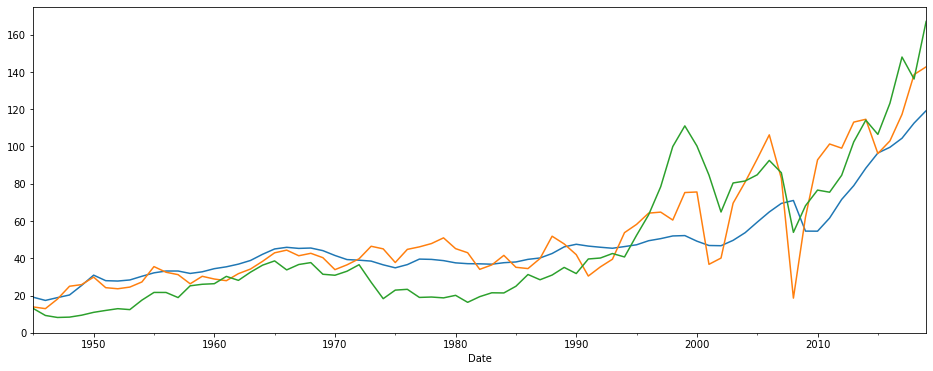

In [14]:
# plot 3 var
# scale to same scale
plt.figure()
(divs*2).plot() # blue
earnings.plot() # orange
(prices/20).plot().set_ylim(0,None) # green

<AxesSubplot:xlabel='Date'>

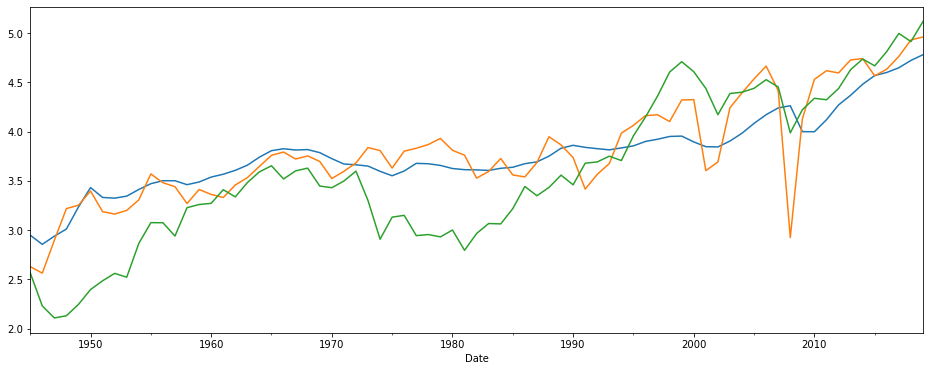

In [15]:
# log transform
logdivs = np.log(divs)
logearnings = np.log(earnings)
logprices = np.log(prices)

# scale
plt.figure()
(logdivs+np.log(2)).plot()
logearnings.plot()
(logprices-np.log(20)).plot()

<AxesSubplot:xlabel='Date'>

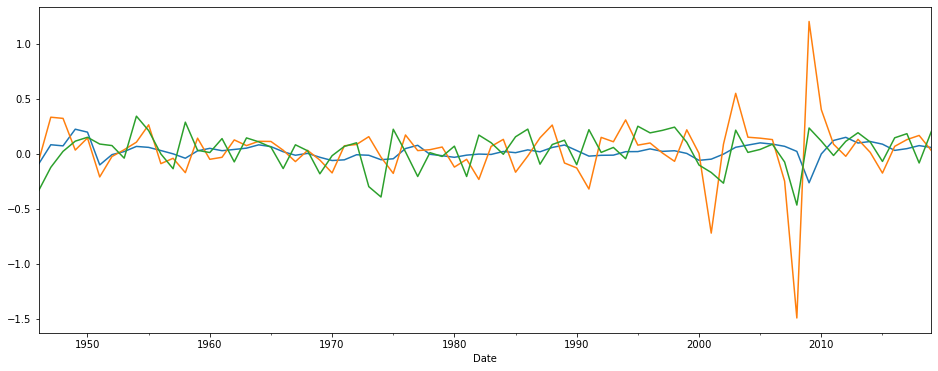

In [16]:
# percentage change
divGrowth = logdivs.diff().dropna()
earnGrowth = logearnings.diff().dropna()
returns = logprices.diff().dropna().rename("returns")

plt.figure()
divGrowth.plot()
earnGrowth.plot()
returns.plot()

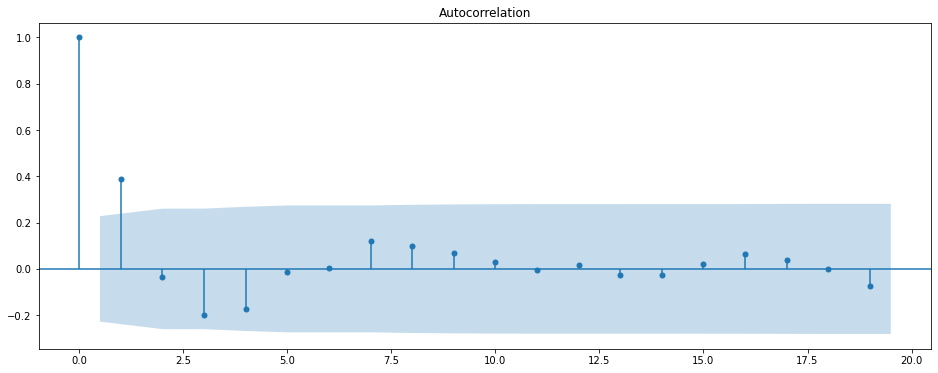

In [17]:
# plot auto correlation for each
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(divGrowth);
# significant at lag 1

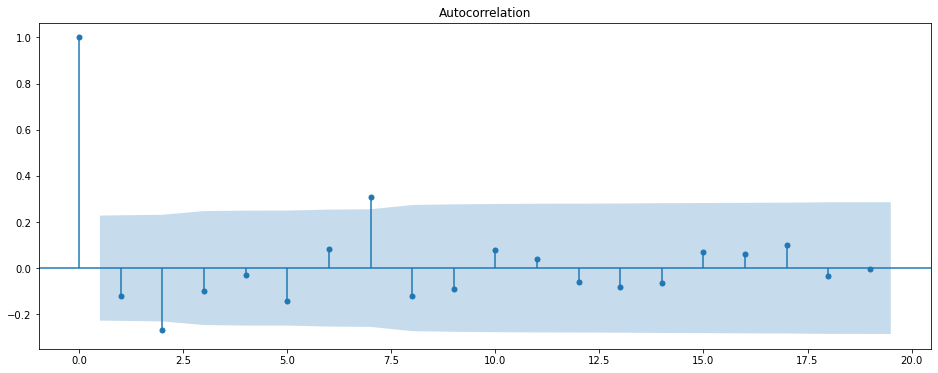

In [18]:
plot_acf(earnGrowth);
# significant at lag 2

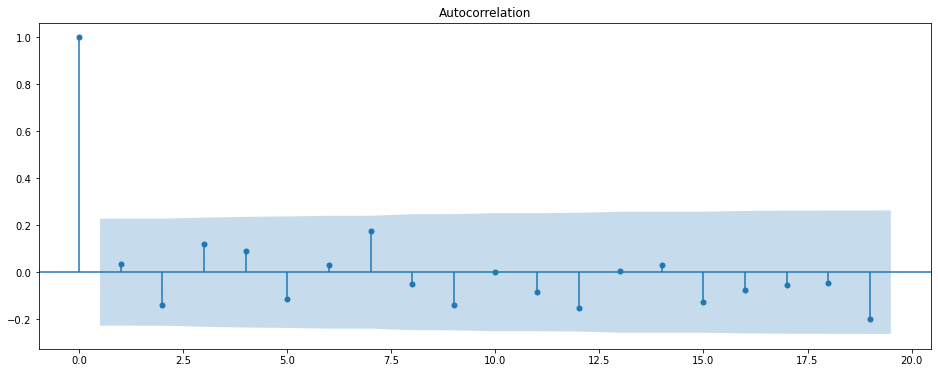

In [19]:
plot_acf(returns);
# no significant (Random Walk)

In [20]:
# put three vars together
df = pd.concat([divGrowth, earnGrowth, returns], axis=1)
df.describe()

,divs,earnings,returns
count,74.000000,74.000000,74.000000
mean,0.024761,0.031505,0.034489
std,0.067610,0.286360,0.162472
min,-0.263294,-1.493037,-0.465843
25%,-0.010887,-0.054911,-0.062923
50%,0.022310,0.049897,0.064437
75%,0.064197,0.131911,0.145565
max,0.224128,1.204188,0.342731


In [21]:
# correlation
# returns & earnings (strong)
# returns & divs (weak)
# earnings & divs (not significant)
# might not be as high if remove outliers
df.corr()

,divs,earnings,returns
divs,1.000000,-0.049263,0.139044
earnings,-0.049263,1.000000,0.347752
returns,0.139044,0.347752,1.000000


[-0.04926259  0.47938877  0.31969605 -0.02107093 -0.17596079 -0.06378437
 -0.1974257  -0.11154092  0.22867684  0.14963013 -0.03092855]


0.23249527748763857

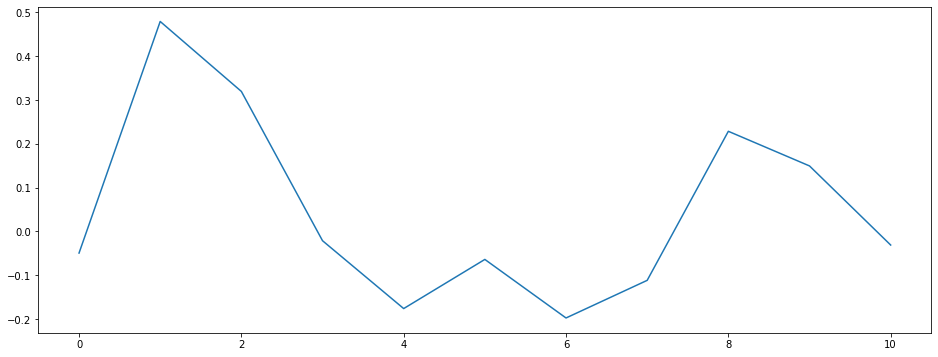

In [26]:
# cross correlation
# divs, earns, returns
from statsmodels.tsa.stattools import ccf
# divs * earns (2)
plt.plot(ccf(divGrowth,earnGrowth)[0:11])  # 2nd series shift 0, 1, 2, 3, ...
print(ccf(divGrowth,earnGrowth)[0:11])
# Shift 1,2 signficant, i.e. div(t) correl w/ earn(t-1), (t-2)
# i.e. earnings predict divs 1- and 2-years ahead
2/len(returns)**0.5 # 95% confidence bands +/- 2 / sqrt(n)

[ 0.13904353  0.34317063  0.06057096 -0.27981402 -0.19185129  0.07920651
 -0.01963221  0.09450513  0.12188187  0.10829615 -0.02780556]


0.23249527748763857

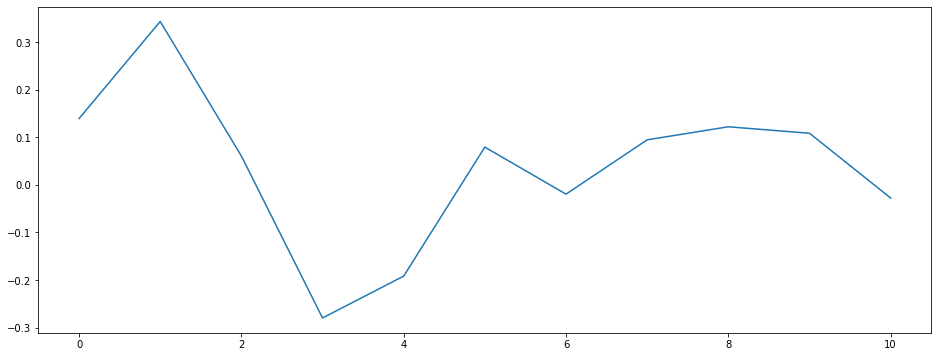

In [25]:
# divs * returns (1)
plt.plot(ccf(divGrowth,returns)[0:11])  # 2nd series shift 0, 1, 2, 3, ...
print(ccf(divGrowth,returns)[0:11])     # Shift 1 is signficant, i.e. div(t) correl w/ returns(t-1)
# i.e. returns predict divs 1 year ahead
2/len(returns)**0.5 # 95% confidence bands +/- 2 / sqrt(n)

[-0.04926259 -0.11874393 -0.16044432 -0.10452656 -0.05885002  0.11055937
  0.20001561  0.12408141 -0.00339224 -0.12366642  0.00813759]


0.23249527748763857

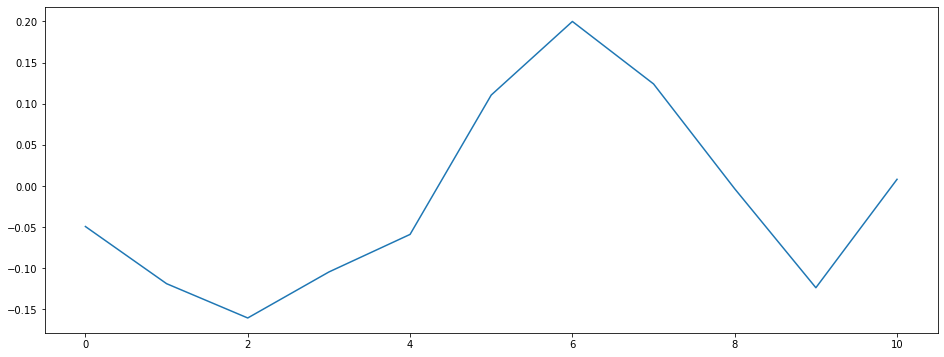

In [27]:
# earn * div 0
plt.plot(ccf(earnGrowth,divGrowth)[0:11])  # 2nd series shift 0, 1, 2, 3, ...
print(ccf(earnGrowth,divGrowth)[0:11])     # Insignificant
2/len(returns)**0.5 # 95% confidence bands +/- 2 / sqrt(n)

[ 0.34775194 -0.02100698 -0.25044343 -0.11514607  0.01676789 -0.0427807
  0.20771867  0.0750129   0.08677466 -0.14086962 -0.13721904]


0.23249527748763857

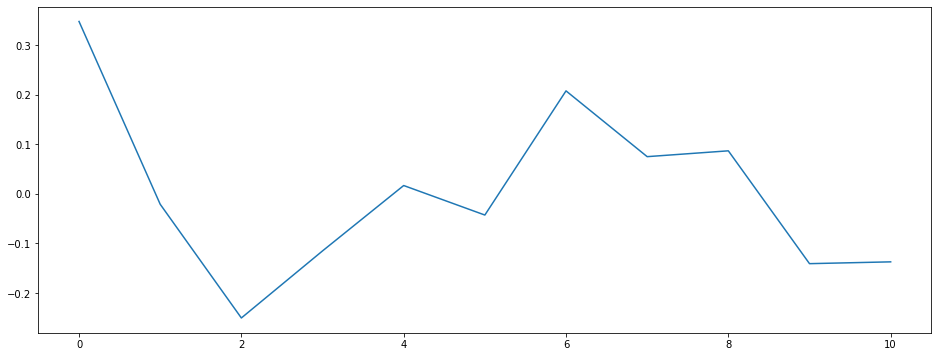

In [23]:
# earn * return 0
plt.plot(ccf(earnGrowth,returns)[0:11])  # 2nd series shift 0, 1, 2, 3, ...
print(ccf(earnGrowth,returns)[0:11])     # Shift 0 and shift 2 is significant but not shift 1?  Ignore shift 2?
2/len(returns)**0.5 # 95% confidence bands +/- 2 / sqrt(n)

[ 0.13904353  0.10981227  0.13401037 -0.05372792 -0.04298127  0.10850214
  0.17774915  0.07816819  0.04099802  0.11852604 -0.06258222]


0.23249527748763857

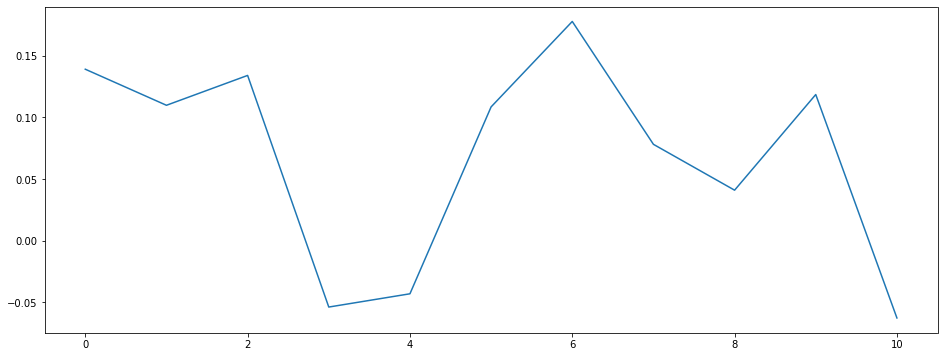

In [24]:
# return * div 0 
plt.plot(ccf(returns,divGrowth)[0:11])  # 2nd series shift 0, 1, 2, 3, ...
print(ccf(returns,divGrowth)[0:11])     # Not signficant.
2/len(returns)**0.5 # 95% confidence bands +/- 2 / sqrt(n)

[ 0.34775194  0.0348649  -0.10358045  0.10063521  0.04882275 -0.19185602
 -0.03416783  0.23642307 -0.07544957 -0.15003368  0.22437801]


0.23249527748763857

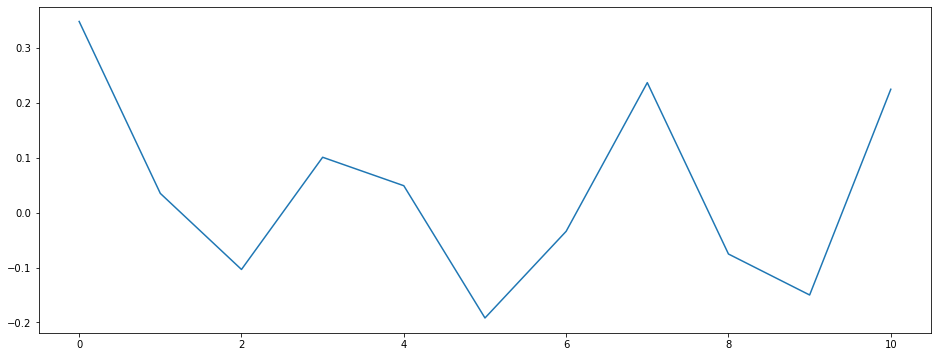

In [25]:
# return * earn 0
plt.plot(ccf(returns,earnGrowth)[0:11])  # 2nd series backshift 0, 1, 2, 3, ... snice earnGrowth.shift(1) = e(t-1)
print(ccf(returns,earnGrowth)[0:11])     # Only shift 0 is significant
2/len(returns)**0.5 # 95% confidence bands +/- 2 / sqrt(n)

Some conclusions:  change in earnings roughly contemporaneous with returns, and divs lag 1-2 years behind.

Also, Python handles data much more elegantly than (base) R.  Perhaps an unfair comparison of pandas vs base R though, since R also its own add-on packages.  Also R is ahead on time series analysis functionality and visualization (e.g. ggplot2 and the rest of the "tidyverse").

In [26]:
from statsmodels.tsa.api import VAR
model = VAR(df)
results = model.fit(0)  # vector random walk with drift; constant vector + vector white noise
results.summary() # matrix is just correlation

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Apr, 2021
Time:                     20:59:55
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.5494
Nobs:                     74.0000    HQIC:                  -11.6055
Log likelihood:           118.778    FPE:                8.78246e-06
AIC:                     -11.6428    Det(Omega_mle):     8.43583e-06
--------------------------------------------------------------------
Results for equation divs
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.024761         0.007860            3.150           0.002

Results for equation earnings
           coefficient       std. error           t-stat            prob
--------------------------------------------------------------

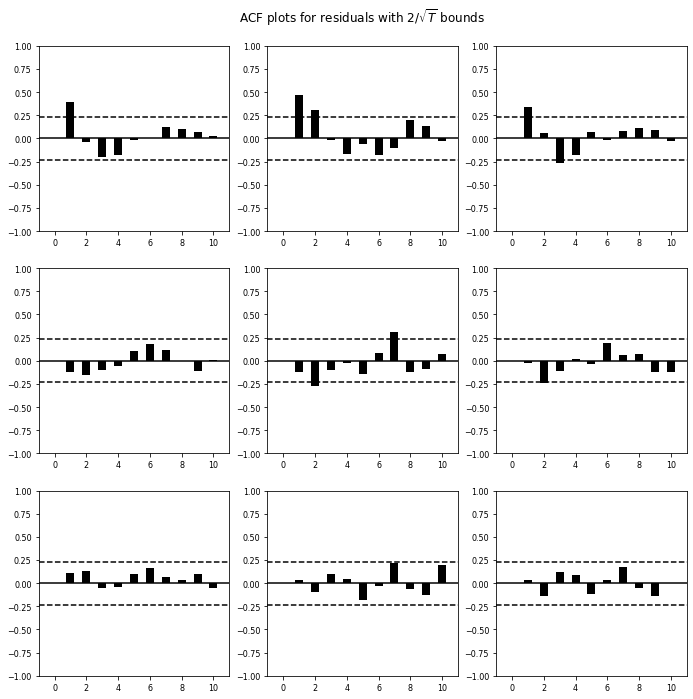

In [32]:
# cross correlation: div earn return
results.plot_acorr();
# How to intrepret this:  The 1st row, 2nd col is the ccf of divs and earnings,
# i.e. corr(divs(t),earnings(t-k)), k > 0
# The signficant correlations at lag 1 and 2 mean earnings lead dividends at those lags.
# Important:  In these plots, the column leads the row.

In [34]:
results = model.fit(1)  # VAR(1)
results.summary()
# each equation coffe is add up
# matrix is different

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Mar, 2021
Time:                     14:25:49
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.7039
Nobs:                     73.0000    HQIC:                  -11.9303
Log likelihood:           142.187    FPE:                5.67148e-06
AIC:                     -12.0804    Det(Omega_mle):     4.83273e-06
--------------------------------------------------------------------
Results for equation divs
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.011638         0.006479            1.796           0.072
L1.divs             0.396305         0.090444            4.382           0.000
L1.earnings         0.105299         0.022560            4.667       

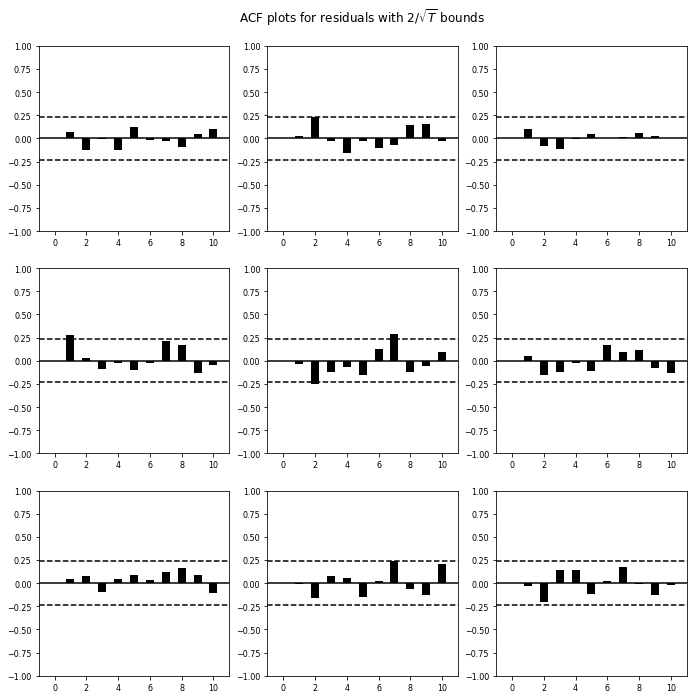

In [35]:
results.plot_acorr();